# dacl-demo

In this demo-notebook we will be importing a dacl-model for the **multi-target classification** of damage on reinforced concrete structures. 
All steps for feeding the dacl model with tasty images of damage will be examined as follows:

1. ***Create the DaclNet-class:*** For being able to instantiate a model, its class, named DaclNet, has to be created. Currently, there are three architectures available based on: ResNet50, EfficientNetV1-B0 and MobileNetV3-Large.
2. ***Preprocess the image***: Before feeding the dacl-model, we need to prepare the image. Our dacl models are very picky regarding their food.
3. ***Feed the dacl-model***: Finally, feed the dacl-model with tasty preprocessed image data.
4. ***Analyze the results***: Analyze the dacl-model's results and try to interpret them.

**HAVE FUN!!!**

<img src='https://dacl.ai/assets/DACL_pixel.png' width=300px>


## Imports
Initially, we have to import the modules we want to use. Make sure that you have installed all prerequisites according to the `requirements.txt` file.

In [1]:
import os 
import random
from pathlib import Path

import numpy as np
import torch
from torch import nn
from torchvision import models

from efficientnet_pytorch import EfficientNet
from efficientnet_pytorch.utils import MemoryEfficientSwish

from PIL import Image
import matplotlib.pyplot as plt
import json


%matplotlib inline

## 1. Create the DaclNet-class

First, we need to define the model with the DaclNet class. Currently there are three architectures available based on: ResNet 50, EfficientNetV1-B0 and MobileNetV3_large. 

In [2]:
# Dict to find the suiting EfficientNet model according to the resolution of the input-images:
efnet_dict = {'b0': 224, 'b1': 240, 'b2': 260, 'b3': 300,   
              'b4': 380, 'b5': 456, 'b6': 528, 'b7': 600    
             }

class DaclNet(nn.Module):
    def __init__(self, base_name, resolution, hidden_layers, num_class, drop_prob=0.2, freeze_base=True):
        ''' 
        Builds a network separated into a base model and classifier with arbitrary hidden layers.
        
        Attributes
        ---------
        base_name: string, basemodel for the NN
        resolution: resolution of the input-images, example: 224, 240...(look efnet_dic), Only needed for EfficientNet
        hidden_layers: list of integers, the sizes of the hidden layers
        drop_prob: float, dropout probability
        freeze_base: boolean, choose if you want to freeze the parameters of the base model
        num_class: integer, size of the output layer according to the number of classes

        Example
        ---------
        model = Network(base_name='efficientnet', resolution=224, hidden_layers=[32,16], num_class=6, drop_prob=0.2, freeze_base=True)
        
        Note
        ---------
        -print(efficientnet) -> Last module: (_swish): MemoryEfficientSwish() and the last fc-layers
         This activation won't be called during forward due to: "self.base.extract_features"! No activation of last layer!
        '''
        super(DaclNet, self).__init__()
        # basemodel
        self.base_name = base_name
        self.resolution = resolution
        self.hidden_layers = hidden_layers
        self.freeze_base = freeze_base

        if self.base_name == 'mobilenet':
            base = models.mobilenet_v3_large(pretrained=True) 
            modules = list(base.children())[:-1] 
            self.base = nn.Sequential(*modules)
            # for pytorch model:
            if hidden_layers:
                self.classifier = nn.ModuleList([nn.Linear(base.classifier[0].in_features, self.hidden_layers[0])]) 
            else:
                self.classifier = nn.Linear(base.classifier[0].in_features, num_class)

            self.activation = nn.Hardswish()

        elif self.base_name == 'resnet':
            base = models.resnet50(pretrained=True) 
            modules = list(base.children())[:-1]
            self.base = nn.Sequential(*modules)
            if self.hidden_layers:
                self.classifier = nn.ModuleList([nn.Linear(base.fc.in_features, self.hidden_layers[0])])
            else:
                self.classifier = nn.Linear(base.fc.in_features, num_class)   
            self.activation = nn.ELU() 

        elif self.base_name == 'efficientnet':      
            for ver in efnet_dict:
                if efnet_dict[ver] == self.resolution:
                    self.version = ver
                    full_name = self.base_name+'-'+ver
            self.base = EfficientNet.from_pretrained(model_name=full_name) 
            if self.hidden_layers:
                self.classifier = nn.ModuleList([nn.Linear(self.base._fc.in_features, self.hidden_layers[0])])
            else:
                self.classifier = nn.Linear(self.base._fc.in_features, num_class)   
            self.activation = MemoryEfficientSwish()
        elif self.base_name == 'mobilenetv2':
            base = models.mobilenet.mobilenet_v2(pretrained=True)
            modules = list(base.children())[:-1]
            self.base = nn.Sequential(*modules)
            if hidden_layers:
                self.classifier = nn.ModuleList([nn.Linear(base.classifier[1].in_features, self.hidden_layers[0])]) 
            else:
                self.classifier = nn.Linear(base.classifier[1].in_features, num_class)
            self.activation = nn.ReLU()
        else:
            raise NotImplementedError    
        
        # freeze the base
        if self.freeze_base:
            for param in self.base.parameters(): 
                param.requires_grad_(False)
        
        self.dropout = nn.Dropout(p=drop_prob, inplace=True)

        # classifier
        # Add a variable number of more hidden layers
        if self.hidden_layers:
            layer_sizes = zip(self.hidden_layers[:-1], self.hidden_layers[1:])        
            self.classifier.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
            # Add output layer to classifier
            self.classifier.append(nn.Linear(self.hidden_layers[-1], num_class))
        else:
            pass
        
    def forward(self, input_batch):
        ''' 
        Performs the feed-forward process for the input batch and returns the logits

        Arguments
        ---------
        input_batch: torch.Tensor, Multidimensional array holding elements of datatype: torch.float32, 
                     its shape: [1, 3, 224, 224] according to N x C x H x W,
                     The input batch carries all pixel values from the images inside the batch
        Note
        ---------
        Every model uses 2d-Average-Pooling with output_size=1 after the feature extraction, or rather before flattening.
        The pooling layer of ResNet50 and MobileNetV3 was kept in the squential -> Doesn't have to be called in forward!
        EffNet had to be implemented with the AdaptiveAvgpool2d in this forward function because of missing pooling when
        calling: "effnet.extract_features(input_batch)"
        Also mobilenetV2 needs the manually added pooling layer.

        Returns
        ---------
        logits: torch.Tensor, shape: [1, num_class], datatype of elements: float
        '''
        # Check if model is one that needs Pooling layer and/or special feature extraction
        if self.base_name in ['efficientnet', 'mobilenetv2']:
            if self.base_name == 'efficientnet':
                x = self.base.extract_features(input_batch)
            else:
                # For MobileNetV2
                x= self.base(input_batch)
            pool = nn.AdaptiveAvgPool2d(1)
            x = pool(x)
        else:
            # For any other model don't additionally apply pooling:
            x = self.base(input_batch)
        
        x = self.dropout(x)         # Originally only in EfficientNet a Dropout after feature extraction is added  
        x = x.view(x.size(0), -1)   # Or: x.flatten(start_dim=1)
        if self.hidden_layers:    
            for i,each in enumerate(self.classifier):
                # Put an activation function and dropout after each hidden layer
                if i < len(self.classifier)-1:
                    x = self.activation(each(x))
                    x = self.dropout(x)
                else:
                    # Don't use an activation and dropout for the last layer
                    logits = each(x)
                    break
        else:
            logits = self.classifier(x)

        return logits


## 2. Preprocessing and helper functions

Before feeding the dacl-model, we need to prepare the image. Our dacl models are very picky regarding their food.
We have to get an image transformed to a tensor with the shape *N x C x H x W* where *N* is the batch-size, *C* the color channels (RGB), *H* the height and *W* the width of the image. Also, there's a function for selecting an arbitrary image and one to display our result next to the classified image.

The datatype of the preprocessed image is: torch.float32 and it's shape is: torch.Size([1, 3, 224, 224])


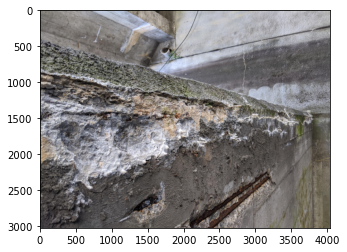

In [3]:
# Preprocessing-function:
def process_img(img_path=None):
	''' 
	Scales, crops, and normalizes a PIL image for a PyTorch model,
	returns a Torch Tensor
	Args: 
		filepath: 	filepath of the image (string)
	Example: process_img('test/1/image_06743.jpg')
	Returns: torch.float32 of shape: [1, 3, 224, 224]
	'''

	if not img_path:
		print('Parse the filename of the image!')
	else:
		#Parse image as PIL Image
		image = Image.open(img_path)
		# Setting Resize Parameters (width and height)
		image_ratio = image.height / image.width
		if  image.width < image.height  or image.width > image.height:
			if image.width < image.height:
				resize = (256, int(image_ratio * 256))
			else:
				resize = (int(256 / image_ratio), 256)
		else:
			resize = (256, 256)
		
		#Setting Cropping parameters
		crop_size = 224
		crop_x = int((resize[0] - crop_size) / 2)
		crop_y = int((resize[1] - crop_size) / 2)
		crop_box = (crop_x, crop_y,crop_x + crop_size, crop_y+crop_size)
	  	
		#Transformation
		pil_image = image.resize(resize)
		pil_image = pil_image.crop(crop_box)
		np_image = np.array(pil_image)
		np_image = (np_image/255 - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]
		np_image = np_image.transpose(2,0,1)
		image = torch.from_numpy(np_image)
		image = image.unsqueeze_(0)
		image = image.type(torch.FloatTensor)
		return image

def rand_img_path(dir=''):
  ''' 
  Returns an arbitrary path to an image file from a directory, also in its subfolders.
  Args: dir(directory)
  Example: rand_img_path('assets/DamageExamples')
  '''
  file = os.path.join(dir, random.choice(os.listdir(dir)))
  if os.path.isdir(file):
    return rand_img_path(file)
  else:
    return file

def view_classify(img_path, result_dict, title=None, normalize=True):
  ''' Function for viewing an image, its predicted classes and the probabilities
      in a horizontal bar chart.
      Args:
      	image_path: 	path to image you want to classify. You can take 
      					random_image_path function so a random image from test-folder will be classified
      	result_dict:  	result_dict (returned by the predict function)
      Returns:
      None - just displays the image next to the bar chart  
  '''

  result_list = list(result_dict.items())
  result_list = sorted(result_list, reverse=False, key=lambda result: result[1])
  cat_names = [x[0] for x in result_list]
  ps = [x[1] for x in result_list]

  fig, (ax1, ax2) = plt.subplots(figsize=(9,12), ncols=2)
  ax1.imshow(plt.imread(img_path))
  ax1.axis('off')
  ax1.set_title(cat_names[-1])
  ax2.barh(range(len(cat_names)), ps, align='center')
  ax2.set_aspect(0.1)
  ax2.set_yticks(np.arange(len(cat_names)))
  ax2.set_yticklabels(cat_names, size='small')
  ax2.set_title('Class Probability')
  ax2.set_xlim(0, 1.1)

  plt.tight_layout()


# Get image and show it:
img_dir = 'assets/DamageExamples'
img_path = rand_img_path(img_dir)
try:
	img = plt.imread(img_path)
except:
	print("ERROR: {} is no image file. Don't leave non-image files in the {} folder or change the img_dir!".format(img_path, img_dir))
plt.imshow(img)

# Preprocess:
img_proc = process_img(img_path)
print("The datatype of the preprocessed image is: {} and it's shape is: {}".format(img_proc.dtype, img_proc.shape))

## 3. Feed the dacl-model
Finally, you can instantiate the model, load a checkpoint of your choice and feed the dacl-model with tasty preprocessed image data. You will see the predicted result under the following code cell.

**Choose a checkpoint from the table below**

## Available Models

| Modelname             | Dataset           | EMR   | F1   | Tag          | Checkpoint                |
|-----------------------|-------------------|-------|------|--------------|---------------------------|
| Code_res_dacl         | codebrim_balanced | 73.73 | 0.85 | ResNet       | Code_res_dacl.pth         |
| Code_mobilev2_dacl    | codebrim_balanced |70.41  | 0.84 | MobileNetV2  | Code_mobilev2_dacl.pth    |
| Code_mobile_dacl      | codebrim_balanced | 69.46 | 0.83 | MobileNet    | Code_mobile_dacl.pth      |
| Code_eff_dacl         | codebrim_balanced | 68.67 | 0.84 | EfficientNet | Code_eff_dacl.pth         |
| McdsBikit_mobile_dacl | mcds_Bikit        | 54.44 | 0.66 | MobileNet    | McdsBikit_mobile_dacl.pth |
| McdsBikit_eff_dacl    | mcds_Bikit        | 51.85 | 0.65 | EfficientNet | McdsBikit_eff_dacl.pth    |
| McdsBikit_res_dacl    | mcds_Bikit        | 48.15 | 0.62 | ResNet       | McdsBikit_res_dacl.pth    |

** *All these models are available via **bikit**. Check out the README for further information!*

********** Output **********
Spalling: 85.00%
CorrosionStain: 93.00%


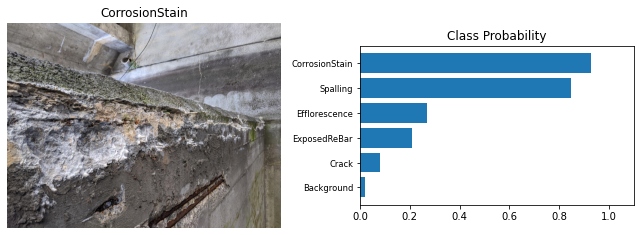

In [4]:
# Choose which checkpoint/model you want to load from the table above:
cp_name = 'Code_mobilev2_dacl.pth'

# Load the checkpoint:
cp = torch.load(Path('models/' + cp_name)) 

# Instantiate the model:
model = DaclNet(base_name=cp['base'], resolution = cp['resolution'], hidden_layers=cp['hidden_layers'], 
				drop_prob=cp['drop_prob'], num_class=cp['num_class'])
model.load_state_dict(cp['state_dict']) # Load the pre-trained wights into the model
model.eval() # Set the model to eval-mode. No dropout and no autograd will be applied.

# Now let's feed the dacl-model in order to  classify the preprocessed image that we imported at the beginning:
logits = model(img_proc)

# Apply sigmoid activation to get predictions:
preds = torch.sigmoid(logits).float().squeeze(0)

# Binarize results:
threshold = .5 # Which threshold do you want to choose for binarization of predictions (for bikit .5 was chosen)?
bin = np.array(preds > threshold, dtype=float)

# In the cat_to_name file our damage-class-names are stored with the according position in the output vector:
with open('cat_to_name.json', 'r') as f:
	cat_to_name = json.load(f)[cp['dataset']]

# Output:
# Make a dict with the predictions:
preds_dict = {v:round(preds[int(k)].item(),2) for k,v in cat_to_name.items()}
print('*'*10, 'Output', '*'*10)
# print('This is the model you have just created:\n', model)
for k,v in preds_dict.items():
	if v > .5:
		print('%s: %.2f%%' % (k,v*100)) 

# View the classified image and it's predictions:
view_classify(img_path, preds_dict)

## InProgress: Analyze the results
Analyze the dacl-model's results and try to interpret them. Here is planned to provide code for testing on test datasets from bikit.